## MLOPs MOdule 1


In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [2]:
# load data
df = pd.read_parquet('green_tripdata_2021-01.parquet')

In [3]:
#df = df[df.trip_type == 2]

In [4]:
# add a duration column which is the start - end time (/ 60 for mins)
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# filter the dataset to equal or greater than 1 minute & euqual to or less than 60 mins
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
# set categorical items to string for encoding
df[categorical] = df[categorical].astype(str)

In [5]:
# create variable to encode the categorical and numerical 
# enter them into a dictionary
train_dicts = df[categorical + numerical].to_dict(orient='records')

# apply encoder to dictionary
dv = DictVectorizer()
# set the encoded dictionary to train data
X_train = dv.fit_transform(train_dicts)

# define the target variable
target = 'duration'
# set the target value to y_train
y_train = df[target].values

#fit a linearregression model on the training data
lr = LinearRegression()
lr.fit(X_train, y_train)

# set prediction to training data
y_pred = lr.predict(X_train)

#compute the mean squared error
mean_squared_error(y_train, y_pred, squared=False)

9.775464329504265

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


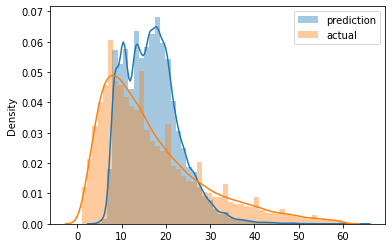

In [6]:
# plot a comparison between the predicitons and actual
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
# define a function which preprocesses the data whether in csv or parquet
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
# setting Jan 2021 to train data
# feb 2021 to validation data
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [9]:
# compare the lengths 
len(df_train), len(df_val)

(73908, 61921)

In [10]:
# create new feature which is the pick up and location id for both
# training and validation sets
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.4795869498500265

In [15]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [16]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728